__DD:__ I got an error and found that I needed to install pandas datareader from Environments in Anaconda Navigator. I also upgraded to the latest Pandas version.  

Also noted many future warnings etc. I compared output's to original provided from 2ds and found almost everything matched with minor exceptions.

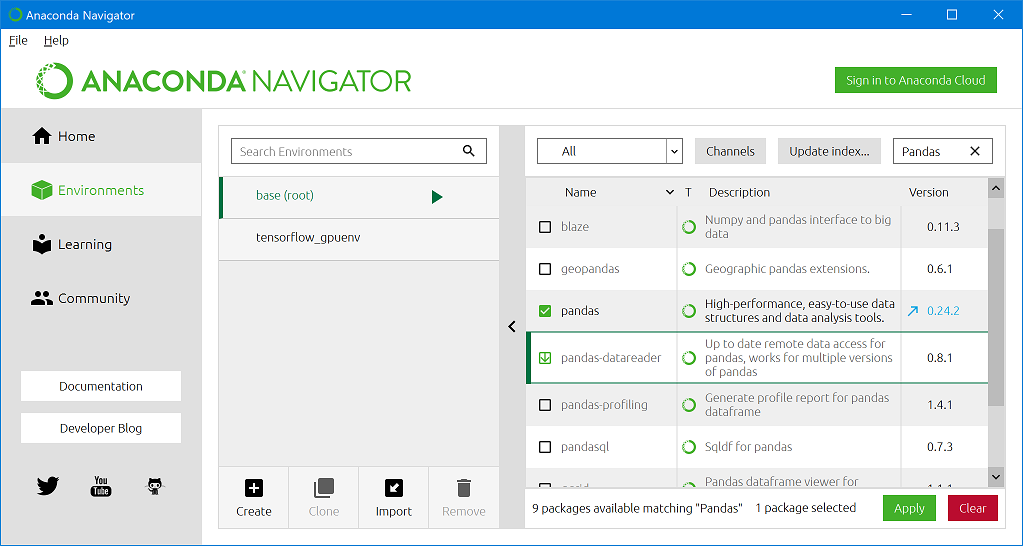

In [1]:
from IPython.display import Image
Image(filename='PandasDataReaderInstall.png') 

__DD:__ Change to your local filesystem.

In [2]:
import os
os.chdir('C:/Users/danie/Documents/GitHub/Quantifying-The-World/Case Study 4')

In [3]:
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
import matplotlib
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline

__DD__ Dickey Fuller test function.

In [4]:
#__DD__ Dickey Fuller Test function
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


## Stock Prices with ARIMA for Gilead Sciences, Inc. (GILD)

In [5]:
import datetime
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as web
start = datetime.datetime(2015, 10, 1)
end = datetime.datetime(2020, 2, 1)
# Change 'iex' to 'yahoo' and capitalize 'close'
price = web.DataReader('GILD', 'yahoo', start, end)['Close']
price.index = pd.to_datetime(price.index)

__DD__ output to .csv so we can try in R as well

In [6]:
#__DD__ output to .csv so we can try in R as well
price.to_csv('price.csv')

C:\Users\danie\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


__DD__ The data is daily:

In [7]:
price.head()

Date
2015-10-01     98.269997
2015-10-02     98.279999
2015-10-05     99.260002
2015-10-06     97.540001
2015-10-07    100.269997
Name: Close, dtype: float64

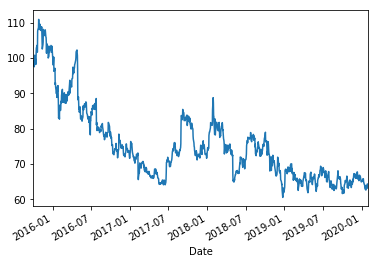

In [8]:
price.plot()

__DD__ We clearly have positive autocorrelation. We probably need high order differencing:

Text(0.5, 1.0, 'Autocorrelation Function')

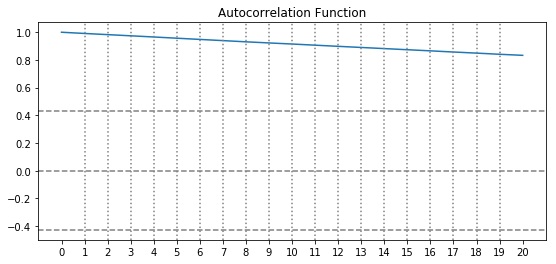

In [9]:
# __DD__ We have positive autocorrelation. 
#We probably need high order differencing:

acf_stock_plot = acf(price, nlags=20, fft=True)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(acf_stock_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_stock_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_stock_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Autocorrelation Function')

__DD__ Partial autocorrelation: We see a sharp cutoff at lag 1. Also lag 1 is postitive (Rule 6):

Text(0.5, 1.0, 'Partial Autocorrelation Function')

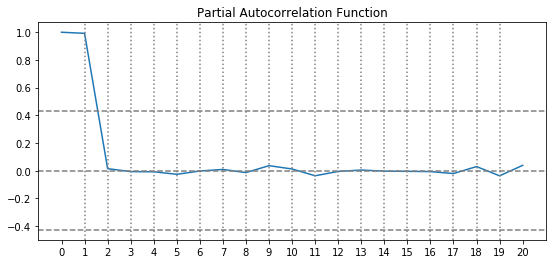

In [10]:
# __DD__ Partial autocorrelation enforces that we probably need high order differencing:

pacf_stock_plot = pacf(price, nlags=20)
#Plot PACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(pacf_stock_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(pacf_stock_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(pacf_stock_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Partial Autocorrelation Function')

__DD__ Perform manual differencing

In [11]:
#__DD__ Perform differencing
diff=price-price.shift()
diff.dropna(inplace=True)

__DD__ Replot after differencing

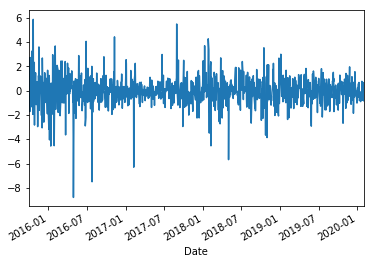

In [12]:
#__DD__ Replot after differencing
diff.plot()

__DD__ Autocorrelation after differencing. Lag 1 is now near 0

Text(0.5, 1.0, 'Autocorrelation Function')

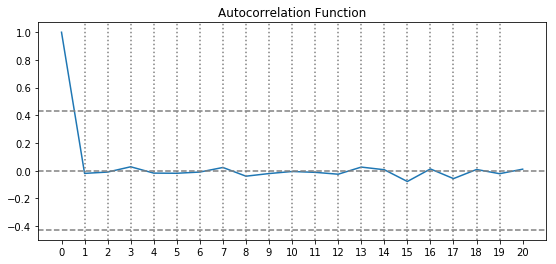

In [13]:
# __DD__ Autocorrelation after differencing

acf_stock_plot = acf(diff, nlags=20, fft=True)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(acf_stock_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_stock_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_stock_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Autocorrelation Function')

__DD__ Partial Autocorrelation after differencing. Lag 1 near 0

Text(0.5, 1.0, 'Partial Autocorrelation Function')

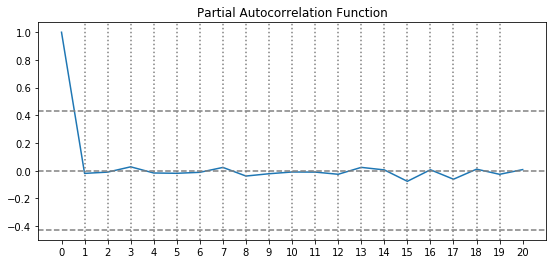

In [14]:
#__DD__ Partial Autocorrelation after differencing
pacf_stock_plot = pacf(diff, nlags=20)
#Plot PACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(pacf_stock_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(pacf_stock_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(pacf_stock_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Partial Autocorrelation Function')

__DD__ Dickey Fuller test before differencing. Note that our test statistic (-2.263735) is greater than our critical value.(-2.864195 at 5%)

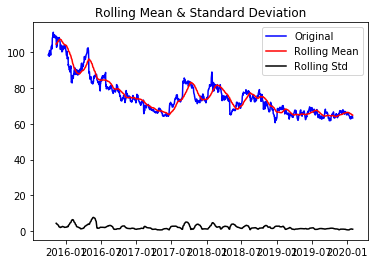

Results of Dickey-Fuller Test:
Test Statistic                   -2.263735
p-value                           0.183931
#Lags Used                        0.000000
Number of Observations Used    1090.000000
Critical Value (1%)              -3.436364
Critical Value (5%)              -2.864195
Critical Value (10%)             -2.568184
dtype: float64


In [15]:
#__DD__ Dickey Fuller test pre differencing
test_stationarity(price)

__DD__ Dickey Fuller test after differencing. The p value is now significant. And Our test statistic (-2.263735) is greater than our critical value.(-2.864195 at 5%).

__DD__ Note that there is some narrowing of the spread: we may want to re-visit this denpending on the accuracy of the final model. (opposite of log transform is sqrt?)

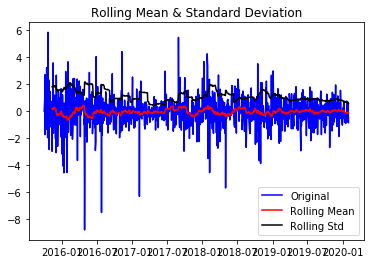

Results of Dickey-Fuller Test:
Test Statistic                  -33.610524
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1089.000000
Critical Value (1%)              -3.436369
Critical Value (5%)              -2.864198
Critical Value (10%)             -2.568185
dtype: float64


In [16]:
#__DD__ Dickey Fuller test after differencing
test_stationarity(diff)

__AutoRegressive__
We definitly have dependance on the past therefore we are at minimum p=1. It is also very likely that we are dependent of more than 1 lag, since intuitively when stocks are trending up or downward investors react to it. Selling or buying the stock presumably affects the price at closing. 
Furthermore our partial autocorrelation plot shows a sharp cutoff and lag 1 and is postitive (Rule 6):With that said we can assume at least p=2.

__Difference__
Intuition tells us that if the price of a stock is volatile over time some may be discouraged from buying, (or perhaps encouraged if looking for a quick buck).   
We also see a downward trend in the plot of the data.  
Furthermore our Dickey Fuller test tells us that we are not stationary. Our test statistic (-2.263735) is greater than our critical value.(-2.864195 at 5%).
With this we assume that at minimum use 1 differencing.
We can also see a time varying trend i.e. the spread decreases over time. As per rule # 4 (time varying trend) we will assume that at least 1 additional order of differencing therefore we will make d=2  

__Moving Average__
The moving average also intuitively has an influence on the stock price but if we have p=2 then we probably do not want q to cancel it out (Rule 8). For now we will make q=1 based on rule of thumb.

__Conclusion:__ p=2, d=2, q=1 Changed to p=2, d=1, q=1

C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1090
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1750.145
Method:                       css-mle   S.D. of innovations              1.205
Date:                Mon, 02 Mar 2020   AIC                           3510.290
Time:                        19:01:24   BIC                           3535.260
Sample:                             1   HQIC                          3519.741
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0322      0.035     -0.909      0.364      -0.102       0.037
ar.L1.D.Close    -0.7728      0.240     -3.220      0.001      -1.243      -0.302
ar.L2.D.Close    -0.0343      0.031     

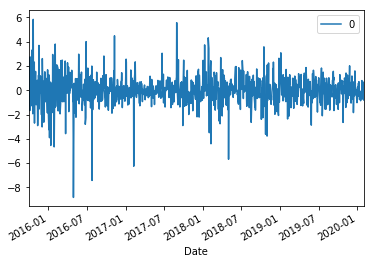

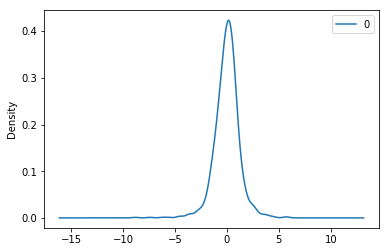

                 0
count  1090.000000
mean      0.000042
std       1.205818
min      -8.821626
25%      -0.604245
50%       0.052442
75%       0.629906
max       5.837830


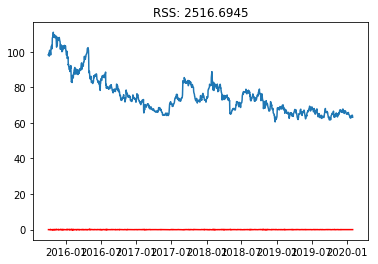

2516.6945159775582


In [17]:
#Raw (not manually differenced) data.
model = ARIMA(price, order=(2,1,1), freq=None)
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())
#################################
plt.plot(price)
plt.plot(model_fit.fittedvalues, color='red')
x=pd.DataFrame(model_fit.fittedvalues)
x=x.join(price)
x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
loss=np.sqrt(x['out'].sum())
plt.title('RSS: %.4f'% loss)

plt.show()
print(loss)

C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1090
Model:                     ARMA(2, 1)   Log Likelihood               -1750.145
Method:                       css-mle   S.D. of innovations              1.205
Date:                Mon, 02 Mar 2020   AIC                           3510.290
Time:                        19:01:25   BIC                           3535.260
Sample:                             0   HQIC                          3519.741
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0322      0.035     -0.909      0.364      -0.102       0.037
ar.L1.Close    -0.7728      0.240     -3.220      0.001      -1.243      -0.302
ar.L2.Close    -0.0343      0.031     -1.125    

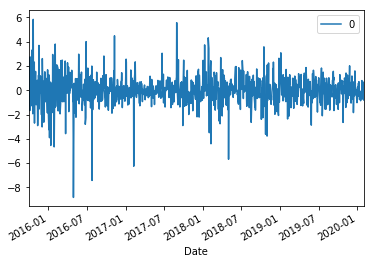

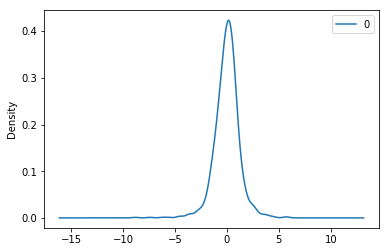

                 0
count  1090.000000
mean      0.000042
std       1.205818
min      -8.821626
25%      -0.604245
50%       0.052442
75%       0.629906
max       5.837830


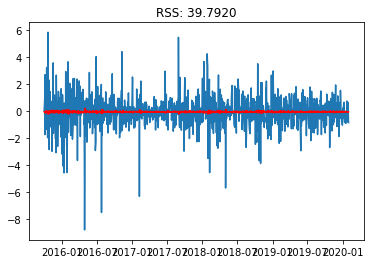

39.79199544296469


In [18]:
#Manually Differenced
model = ARIMA(diff, order=(2,0,1), freq=None)
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())


#################################
plt.plot(diff)
plt.plot(model_fit.fittedvalues, color='red')
x=pd.DataFrame(model_fit.fittedvalues)
x=x.join(diff)
x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
loss=np.sqrt(x['out'].sum())
plt.title('RSS: %.4f'% loss)

plt.show()
print(loss)

39.8172336714145


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


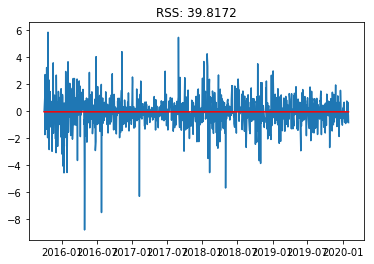

0 0 0
39.80956082852377

C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


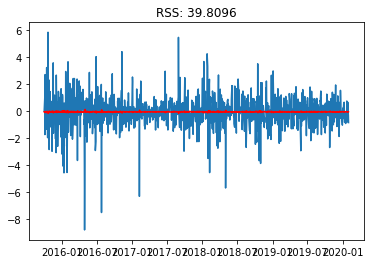

C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0 0 1
39.8079952817471


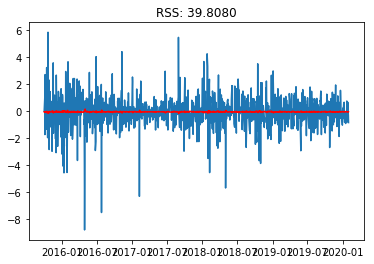

0 0 2


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


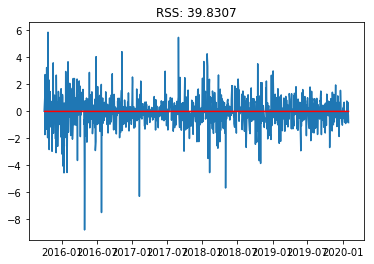

C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0 1 0


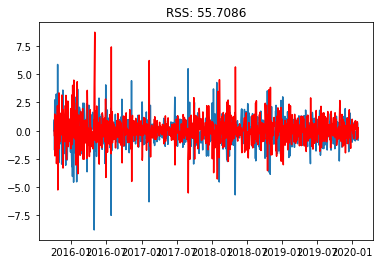

0 1 1


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


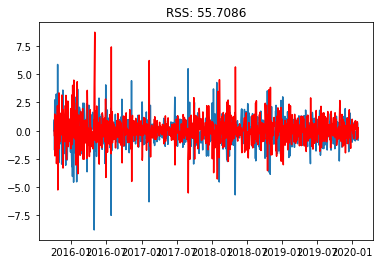

0 1 2


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


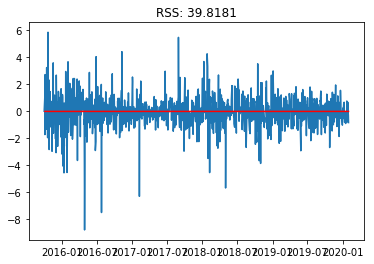

C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0 2 0


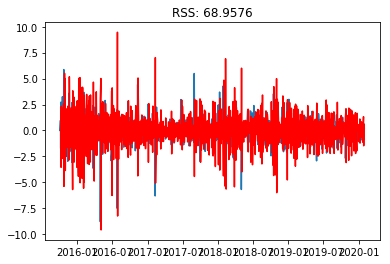

0 2 1


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


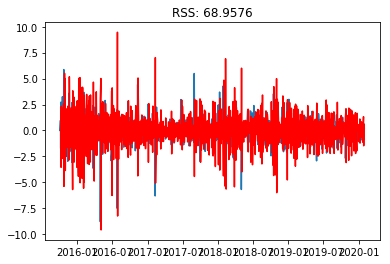

0 2 2


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


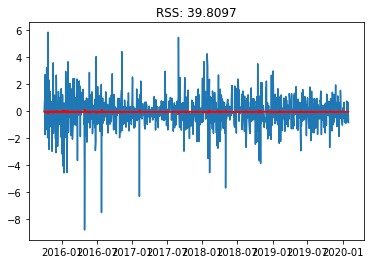

C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1 0 0


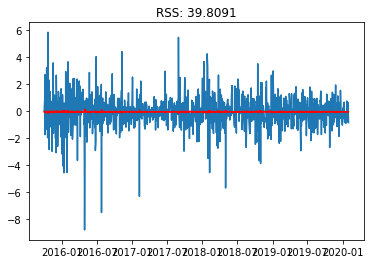

1 0 1


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


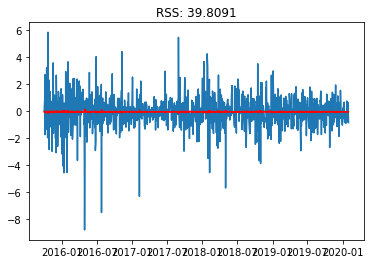

1 0 2


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


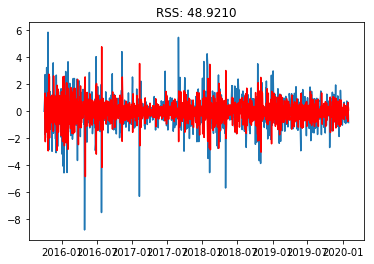

C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1 1 0


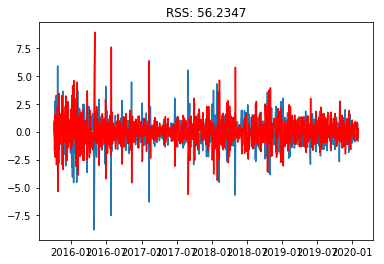

1 1 1


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


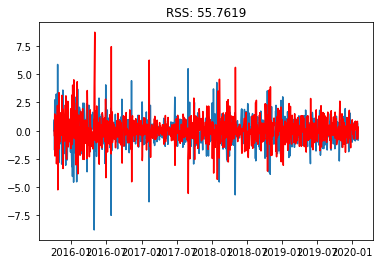

1 1 2


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


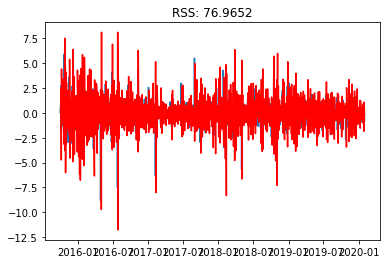

1 2 0


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


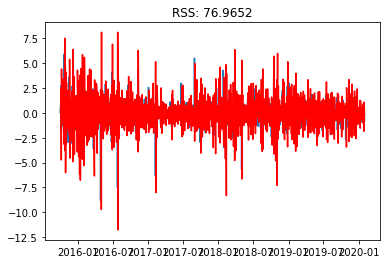

1 2 1


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


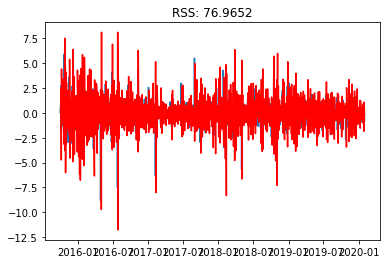

1 2 2
39.807649882615706

C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


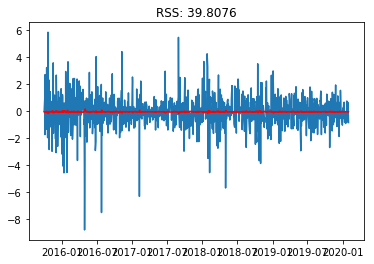

C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2 0 0
39.79199544296469


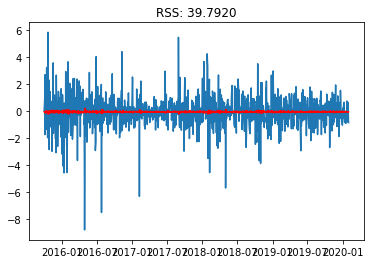

2 0 1


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


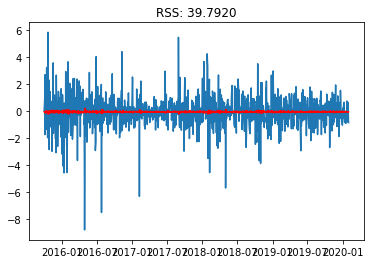

2 0 2


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


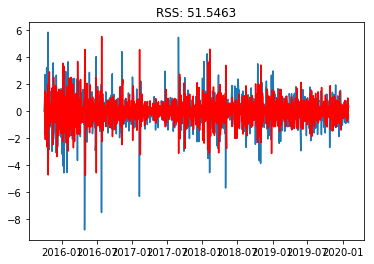

C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2 1 0


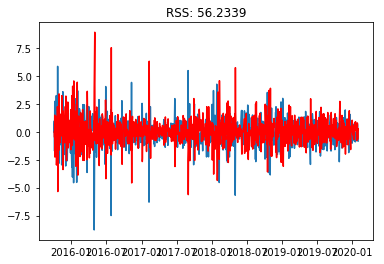

2 1 1


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


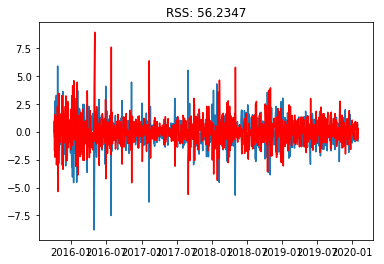

2 1 2


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


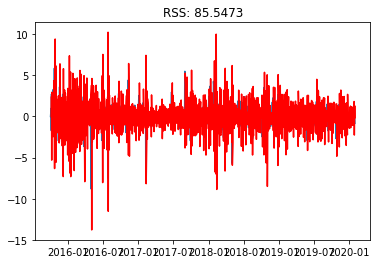

2 2 0


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


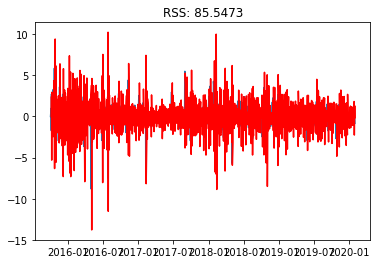

C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2 2 1


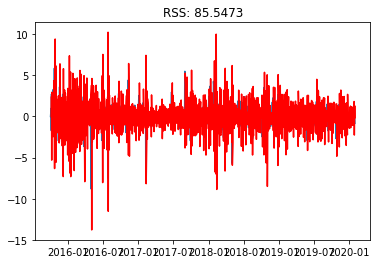

C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2 2 2


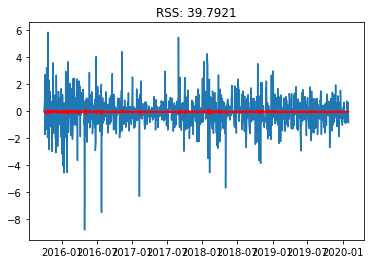

C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3 0 0
39.7879332083734


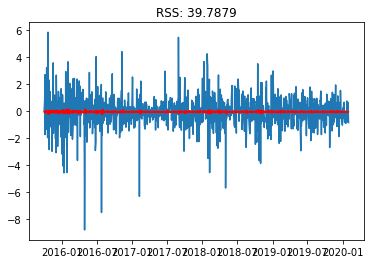

3 0 1


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


39.78750514718411


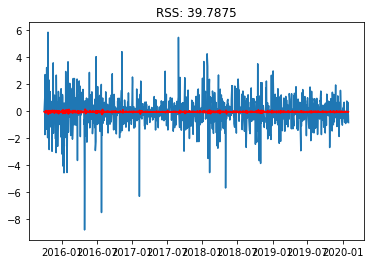

3 0 2


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


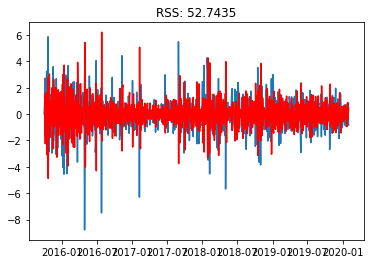

3 1 0


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


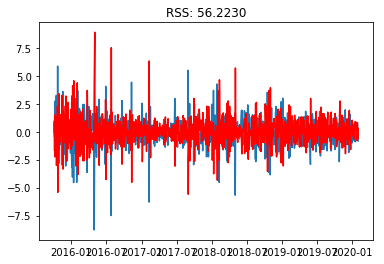

3 1 1


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


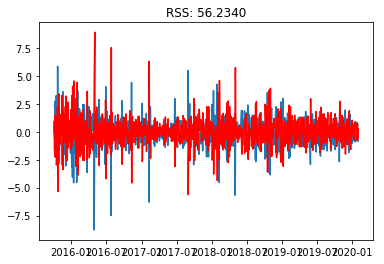

3 1 2


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


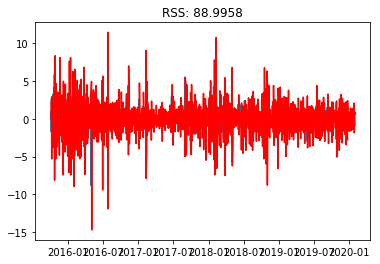

3 2 0


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


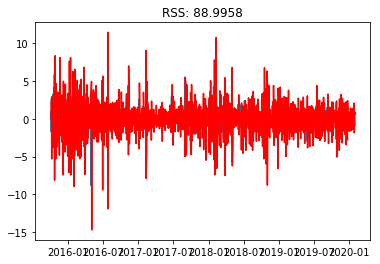

3 2 1


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


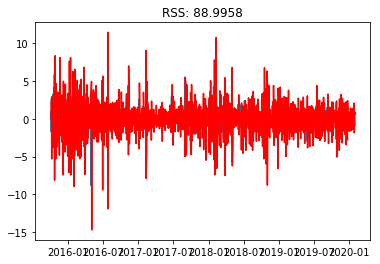

3 2 2


In [19]:
#Manually differenced data.
loss_best = 1E16
best_ints = [-1,-1,-1]
for p in range(4):
    for d in range(3):
        for q in range(3):
            model = ARIMA(diff, order=(p, d, q))  
            try:
                results_ARIMA = model.fit(disp=-1)
            except ValueError:
                pass
            except:
                pass
            plt.plot(diff)
            plt.plot(results_ARIMA.fittedvalues, color='red')
            x=pd.DataFrame(results_ARIMA.fittedvalues)
            x=x.join(diff)

            x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
            loss=np.sqrt(x['out'].sum())
            plt.title('RSS: %.4f'% loss)
            if loss < loss_best:
                print(loss)
                loss_best = loss
                best_ints=[p,d,q]
            plt.show()
            print(p,d,q)

In [20]:
#Manually differenced
differencedbestints = best_ints
print(differencedbestints)
print(loss_best)

[3, 0, 2]
39.78750514718411


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


359.157195090002


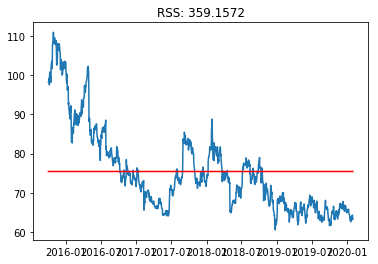

0 0 0


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


195.08119204311947


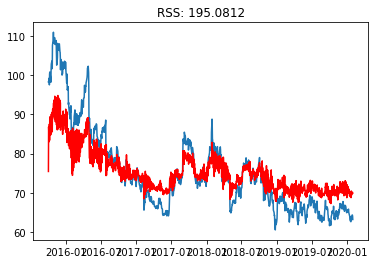

0 0 1
127.6088593097812


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


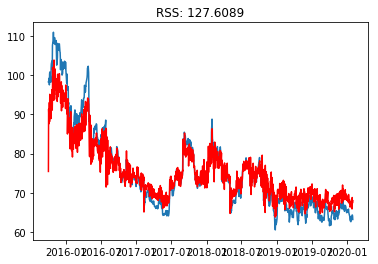

0 0 2


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


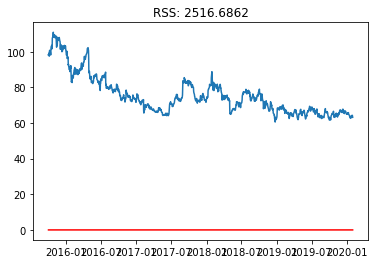

0 1 0


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


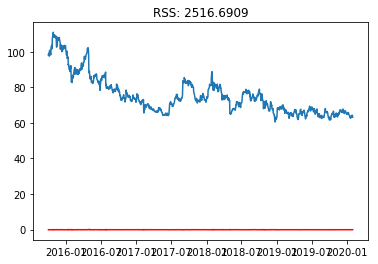

C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0 1 1


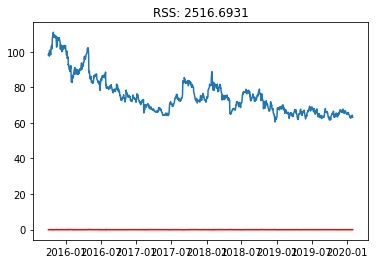

C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0 1 2


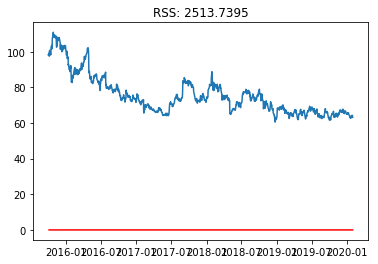

C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0 2 0


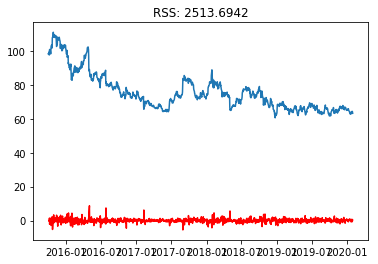

0 2 1


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


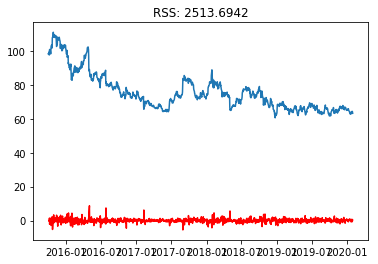

0 2 2
45.13429733582794


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


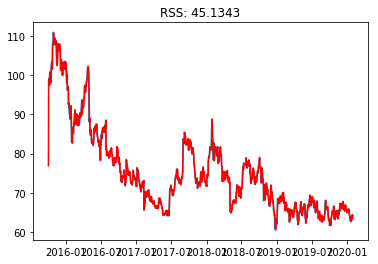

C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1 0 0
45.10896045411799


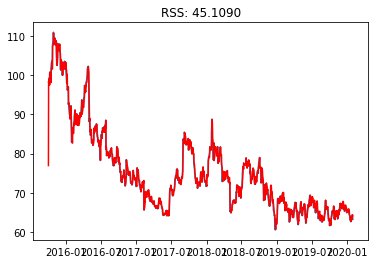

1 0 1
45.101008961807906


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


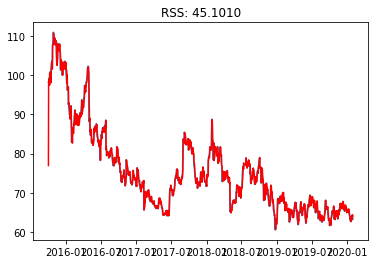

1 0 2


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


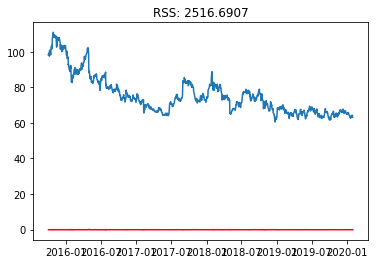

1 1 0


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


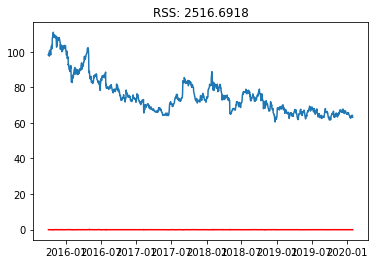

1 1 1


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


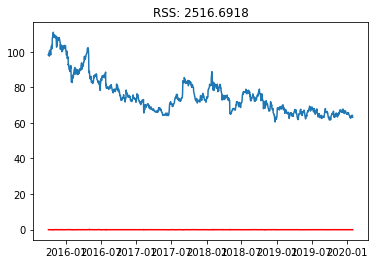

1 1 2


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


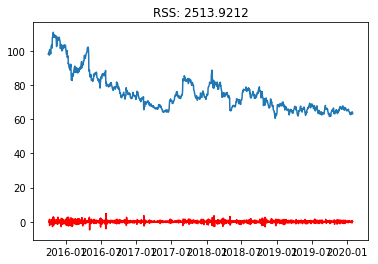

C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1 2 0


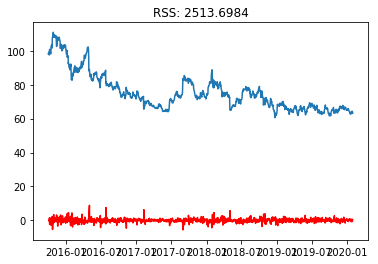

1 2 1


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


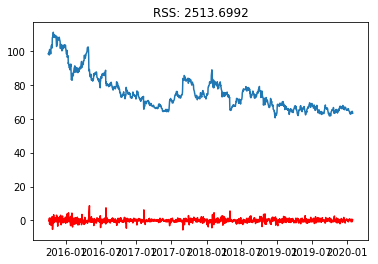

1 2 2


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


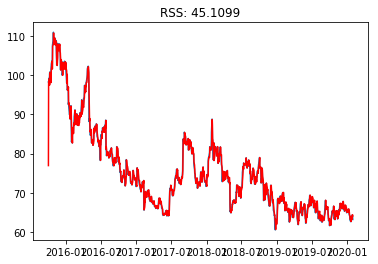

2 0 0


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


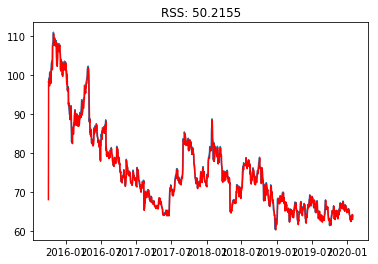

C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2 0 1
45.07963223306626


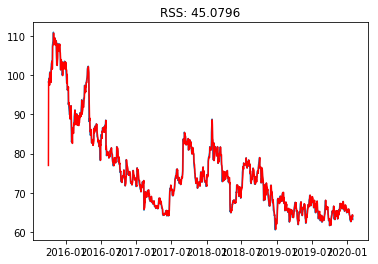

2 0 2


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


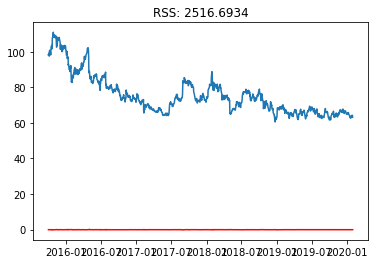

2 1 0


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


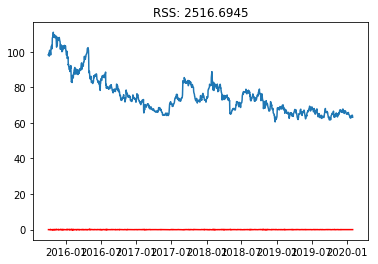

2 1 1


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


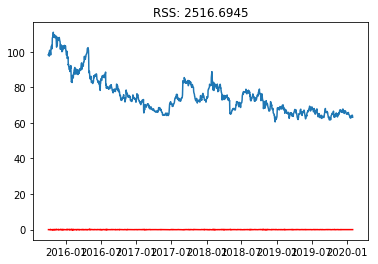

2 1 2


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


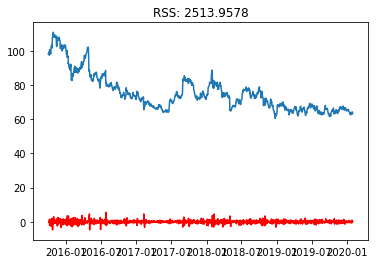

C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2 2 0


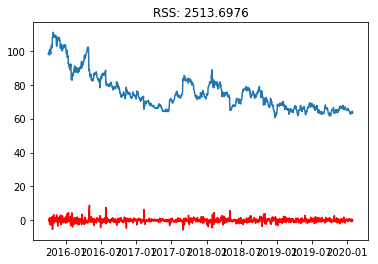

2 2 1


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


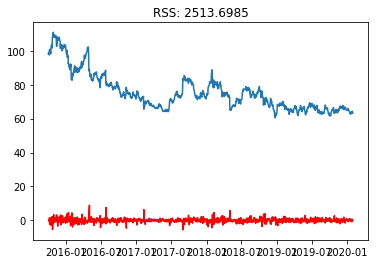

2 2 2


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


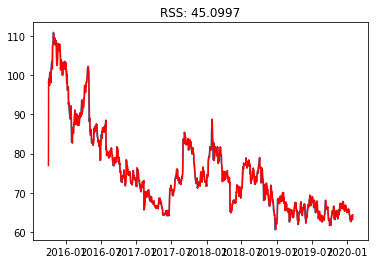

3 0 0


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


45.078082598180536


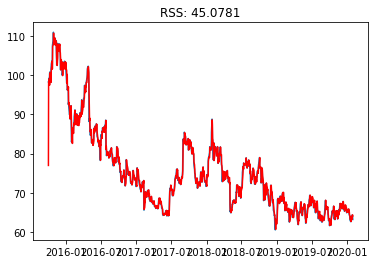

3 0 1


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


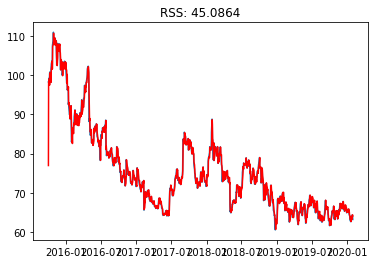

3 0 2


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


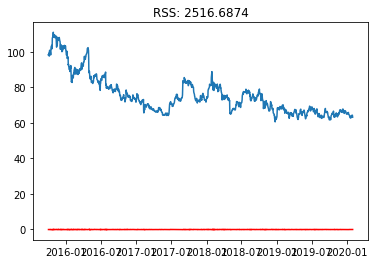

3 1 0


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


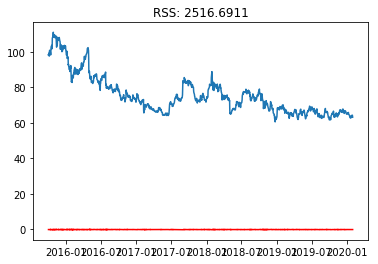

3 1 1


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


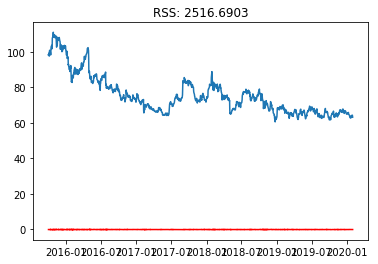

3 1 2


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


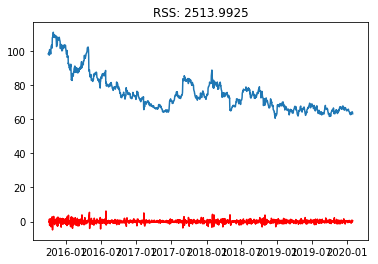

3 2 0


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


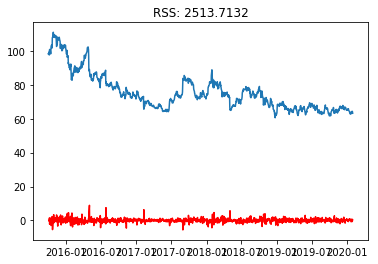

3 2 1


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


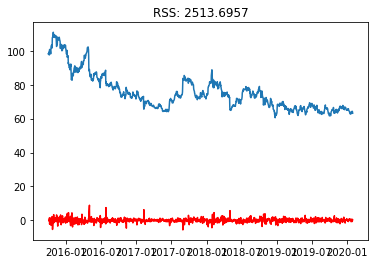

3 2 2


In [21]:
#Raw (not manually differenced) data.
loss_best = 1E16
best_ints = [-1,-1,-1]
for p in range(4):
    for d in range(3):
        for q in range(3):
            model = ARIMA(price, order=(p, d, q))  
            try:
                results_ARIMA = model.fit(disp=-1)
            except ValueError:
                pass
            except:
                pass
            plt.plot(price)
            plt.plot(results_ARIMA.fittedvalues, color='red')
            x=pd.DataFrame(results_ARIMA.fittedvalues)
            #Changed this from diff to price. Error on professor part?
#             x=x.join(diff)
            x=x.join(price)

            x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
            loss=np.sqrt(x['out'].sum())
            plt.title('RSS: %.4f'% loss)
            if loss < loss_best:
                print(loss)
                loss_best = loss
                best_ints=[p,d,q]
            plt.show()
            print(p,d,q)

In [22]:
#Raw (not manually differenced) data.
rawbestints = best_ints
print(rawbestints)
print(loss_best)

[3, 0, 1]
45.078082598180536


 __DD__ Apparently manual differencing improves our result however our rule says that we should be cautious of p and q canceling each other out. In our case the Grid chose 2,0,2 using manually differenced data.. 

Our not manually differenced grid chose p=3, d=0, q = 1. This also breaks one of the rules because we are confident that we require differencing.

In [23]:
#Manually differenced
stock_price = diff.astype(float)

model = ARIMA(stock_price.dropna(), order=(2, 0, 2))  
results_ARIMA = model.fit(disp=-1)

plt.plot(stock_price)
plt.plot(results_ARIMA.fittedvalues, color='red')
x=pd.DataFrame(results_ARIMA.fittedvalues)
x=x.join(stock_price)
x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
loss=np.sqrt(x['out'].sum())
plt.title('RSS: %.4f'% loss)

plt.show()
print(loss)

C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 1089
Model:                 ARIMA(3, 2, 2)   Log Likelihood               -1752.880
Method:                       css-mle   S.D. of innovations              1.206
Date:                Mon, 02 Mar 2020   AIC                           3519.760
Time:                        19:03:56   BIC                           3554.711
Sample:                             2   HQIC                          3532.989
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5.371e-05      0.000      0.476      0.634      -0.000       0.000
ar.L1.D2.Close    -0.9959      0.245     -4.071      0.000      -1.475      -0.517
ar.L2.D2.Close    -0.0280      0.043

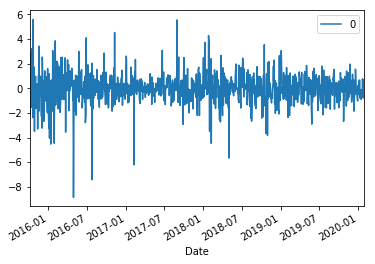

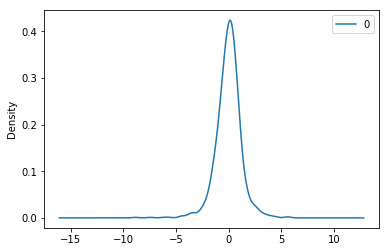

                 0
count  1089.000000
mean     -0.012712
std       1.213461
min      -8.861586
25%      -0.600483
50%       0.053868
75%       0.628932
max       5.595662


In [24]:
#Manually differenced
print(results_ARIMA.summary())
# plot residual errors
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


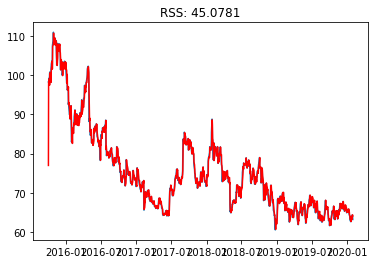

45.078082598180536


In [25]:
#Not manually differenced
stock_price = price.astype(float)

model = ARIMA(stock_price.dropna(), order=(3, 0, 1))  
results_ARIMA = model.fit(disp=-1)

plt.plot(stock_price)
plt.plot(results_ARIMA.fittedvalues, color='red')
x=pd.DataFrame(results_ARIMA.fittedvalues)
x=x.join(stock_price)
x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
loss=np.sqrt(x['out'].sum())
plt.title('RSS: %.4f'% loss)

plt.show()
print(loss)

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1091
Model:                     ARMA(3, 1)   Log Likelihood               -1753.556
Method:                       css-mle   S.D. of innovations              1.205
Date:                Mon, 02 Mar 2020   AIC                           3519.112
Time:                        19:04:05   BIC                           3549.081
Sample:                             0   HQIC                          3530.454
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          76.9871      6.749     11.407      0.000      63.759      90.215
ar.L1.Close     0.2208      0.237      0.934      0.351      -0.243       0.684
ar.L2.Close     0.7405      0.238      3.106    

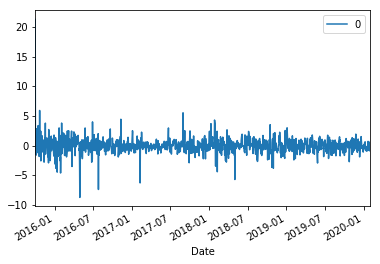

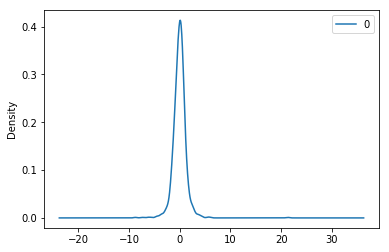

                 0
count  1091.000000
mean     -0.020484
std       1.365222
min      -8.750774
25%      -0.658102
50%       0.006911
75%       0.597449
max      21.282926


In [26]:
#Not manually differenced
print(results_ARIMA.summary())
# plot residual errors
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())